In [1]:
!pip install pyLDAvis emot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 8.9 MB/s eta 0:00:00


In [22]:
# imports
import pandas as pd
import nltk
import spacy
import numpy as np
from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import gensim

from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, MWETokenizer

from emot.emo_unicode import UNICODE_EMOJI
from wordcloud import WordCloud

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc
from gensim.models.coherencemodel import CoherenceModel

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
emoji = list(UNICODE_EMOJI.keys())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [5]:
stop_words = stopwords.words('english')
stop_words.extend(['that', '\"', '[deleted]', '[removed]', '>', 'woman', 'women'])

In [6]:
from google.colab import files
file = files.upload()

Saving processed_data.csv to processed_data.csv
Saving tf-idf.csv to tf-idf.csv
Saving comments-WIT.csv to comments-WIT.csv
Saving posts-WIT.csv to posts-WIT.csv


In [ ]:
# Scrape data
# import praw

# reddit = praw.Reddit("test", config_interpolation="basic")

# def scrape_data(subreddit, query: str = ""):
#     posts = []
#     comments = []
#     for post in reddit.subreddit(subreddit).hot(limit = None):
#     # .search(query = query, limit = 2000, sort = "relevance"):
#         posts.append([post.title, post.score, post.id, post.permalink, post.num_comments])
#         post.comments.replace_more(limit = 0)
#         all_comments = post.comments.list()
#         for comment in all_comments:
#             if comment == "" or comment.author == None or comment.body.lower() == "[deleted]" or comment.body.lower() == "[removed]":
#                 continue
#             comments.append([post.id, comment.body])
#     return posts, comments

# posts, comments = scrape_data("todayilearned")
# print(len(posts), len(comments))

# # load data
# posts_df = pd.DataFrame(posts, columns=['text', 'score', 'id', 'link', 'num_of_comments'])
# comments_df = pd.DataFrame(comments, columns=['postid', 'text'])

# print(posts_df.head())
# print(comments_df.head())

# # save
# posts_df.to_csv("posts_TIL.csv")
# comments_df.to_csv("comments_TIL.csv")


In [7]:
# Read saved comments data
posts_df = pd.read_csv("posts-WIT.csv", header=0)
comments_df = pd.read_csv("comments-WIT.csv", header=0)

print(posts_df.head())
print(comments_df.head())

                                                text  score       id  \
0  Candidate cried during interview--what would y...   1196  189ahan   
1                      Women Who Code will shut down   1182  1c7dabu   
2                            Discrimination at Apple    980  187s5r8   
3   Male colleagues walked away from the lunch table    762  17s3jgn   
4  [Ineffectual rant] My partner just did the thi...    642  1bqxcdg   

                                                link  num_of_comments  
0  /r/womenintech/comments/189ahan/candidate_crie...              542  
1  /r/womenintech/comments/1c7dabu/women_who_code...              197  
2  /r/womenintech/comments/187s5r8/discrimination...              226  
3  /r/womenintech/comments/17s3jgn/male_colleague...              427  
4  /r/womenintech/comments/1bqxcdg/ineffectual_ra...               95  
    postid                                               text
0  189ahan  I've been in IT for 15 years, working with all...
1  189ahan 

In [7]:
data_df = comments_df

In [8]:
# preprocess the text
def preprocess(text, pos_tags = {'ADJ', 'ADV', 'NOUN', 'VERB', 'PRON', 'CONJ'}):
  text = re.sub(r'(\w+:\/\/\S+)|/|\\', ' ', text)
  text = ' '.join(re.sub('([^0-9A-Za-z \t])',' ',text).split())
  text = re.sub(r'\#\w+|\d+','',text)
  text = text.lower()
  # remove punctuation, digits
  punct = str.maketrans('', '', string.punctuation + string.digits)
  text = text.translate(punct)
  tokens = word_tokenize(text)
  filtered_words = [w for w in tokens if w not in stop_words and w not in emoji and len(w) > 4 and '-' not in w]
  tagged_words = pos_tag(filtered_words, tagset='universal')
  filtered_words = [word for word, pos in tagged_words if pos in pos_tags]
  lemmatizer = WordNetLemmatizer()
  lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
  return lemma_words

In [9]:
data_df.dropna(subset=['text'], how = 'any', axis = 0, inplace = True )
data_df['Processed_Text'] = data_df['text'].apply(preprocess)
data_df.head()

postid                                               text  \
0  189ahan  I've been in IT for 15 years, working with all...   
1  189ahan  I use SQL regularly and have never heard those...   
2  189ahan  I’m a very good senior programmer and an inter...   
3  189ahan  Wtf is a senior director doing interviewing a ...   
4  189ahan  I’ve been using SQL for 30 years, have an Orac...   

                                      Processed_Text  
0  [year, working, stuff, listed, varying, capaci...  
1  [regularly, never, heard, term, could, probabl...  
2  [senior, programmer, interview, would, absolut...  
3  [senior, director, interviewing, junior, need,...  
4  [using, year, oracle, certification, written, ...

In [10]:
tokens = data_df['Processed_Text'].to_list()

In [11]:
# compute bigrams, trigrams
bigram = gensim.models.Phrases(tokens, min_count = 3, threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram)
bigram_documents = [bigram_mod[x] for x in tokens]

trigram = gensim.models.Phrases(bigram[tokens], min_count = 3, threshold=10)
trigram_mod = gensim.models.phrases.Phraser(trigram)
trigram_documents = [trigram_mod[bigram_mod[x]] for x in tokens]

# Extract bigrams and trigrams, convert to tuples
bigrams = list(bigram_mod.phrasegrams.keys())
trigrams = list(trigram_mod.phrasegrams.keys())

bigrams_tuples = [tuple(bigram.split('_')) for bigram in bigrams]
trigrams_tuples = [tuple(trigram.split('_')) for trigram in trigrams]

print(len(bigrams_tuples), len(trigrams_tuples))

1747 1870


In [12]:
# Tokenise with bigrams, trigrams
mwe_tokenizer = MWETokenizer(bigrams_tuples + trigrams_tuples)
documents = [mwe_tokenizer.tokenize(item) for item in tokens]
data_df["Processed_Text"] = documents

In [13]:
data_df.dropna(subset=['Processed_Text'], how = 'any', axis = 0, inplace = True )
rows_to_drop = data_df['Processed_Text'].apply(len) == 0
data_df.drop(data_df[rows_to_drop].index, inplace=True)
data_df.reset_index(drop=True, inplace=True)

In [14]:
tokens = data_df['Processed_Text'].to_list()

In [15]:
# TF-IDF to get very common terms
processed_documents = [" ".join(elem) for elem in tokens]
documents = ["".join(doc) for doc in processed_documents]

In [ ]:
# Compute TF-IDF scores
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
features = tfidf_vectorizer.get_feature_names_out()

# Calculate average TF-IDF scores
term_tfidf_scores = defaultdict(float)
for doc_idx, doc in enumerate(processed_documents):
    for term_idx, term in enumerate(features):
        term_tfidf_scores[term] += tfidf_matrix[doc_idx, term_idx]

In [16]:
# read computed term frequencies
df = pd.read_csv("tf-idf.csv", header=0)
term_tfidf_scores = dict(zip(df.iloc[:, 0], df.iloc[:, 1]))

In [17]:
num_of_documents = len(processed_documents)
for term in term_tfidf_scores:
    term_tfidf_scores[term] /= num_of_documents

In [18]:
# filter tokens
threshold = 0.007
common_terms = [term for term, score in term_tfidf_scores.items() if score >= threshold]
len(common_terms)

27

In [19]:
def filterTokens(text, tokens_to_remove):
  return [token for token in text if token not in tokens_to_remove]

data_df["Processed_Text_Filtered"] = data_df["Processed_Text"].apply(filterTokens, tokens_to_remove=common_terms)
data_df["Processed_Text_Filtered"].head()

0    [stuff, listed, varying, capacity, answer, ret...
1    [regularly, never_heard, term, probably, provi...
2    [senior, programmer, absolutely, judging, resp...
3    [senior_director, interviewing, junior, need, ...
4    [using, oracle, certification, written, parser...
Name: Processed_Text_Filtered, dtype: object

In [20]:
data_df["Processed_Text_String"] = [" ".join(data_df["Processed_Text_Filtered"][i]) for i in range(0, len(data_df))]
data_df["Processed_Text_String"].head()

0    stuff listed varying capacity answer retain kn...
1    regularly never_heard term probably provide qu...
2    senior programmer absolutely judging respond b...
3    senior_director interviewing junior need regar...
4    using oracle certification written parser talking
Name: Processed_Text_String, dtype: object

In [21]:
def display_word_cloud(word_cloud, title):
  fig, ax = plt.subplots(figsize=(15,8))
  plt.suptitle(title, fontsize=30)
  ax.imshow(word_cloud, interpolation="bilinear")
  ax.axis("off")

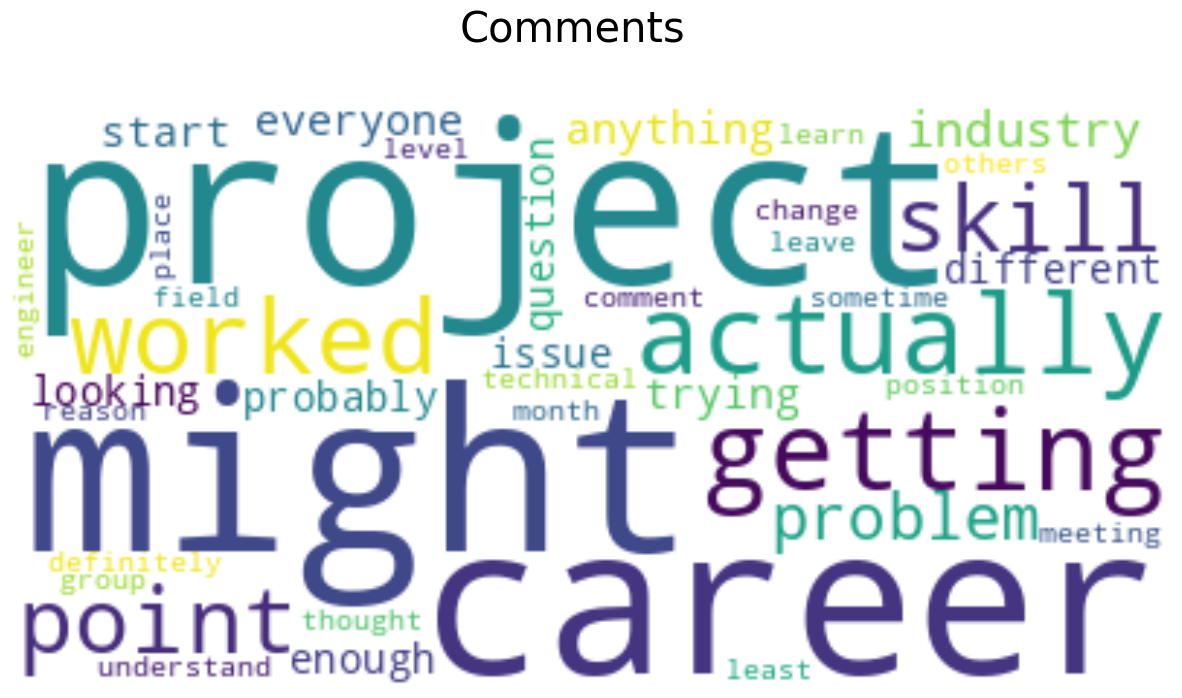

In [22]:
long_string = ','.join(list(data_df['Processed_Text_String'].values))
wordcloud = WordCloud(background_color="white", max_words=40, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
# Visualize
display_word_cloud(wordcloud, "Comments")

In [23]:
def generate_word_cloud(data, stop_words = None, max_words = 30, background_color = 'white'):
  texts = " ".join(elem for elem in data)
  word_cloud = WordCloud(width=800,
                  stopwords=stop_words,
                  height=400,
                  max_font_size=200,
                  max_words=max_words,
                  collocations=True,
                  background_color=background_color)
  return word_cloud.generate(texts)

In [25]:
def plot_distribution(title, values, classes = ['Positive', 'Negative', 'Neutral'], colors = ['lightblue', 'red', 'lightgreen']):
  plt.pie(values, labels=classes, autopct='%1.1f%%', startangle=140, colors = colors)
  plt.title(title)
  plt.axis('equal')
  plt.show()


## Sentiment analysis with VADER

In [26]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [27]:
analyzer = SentimentIntensityAnalyzer()

In [28]:
def vader_sentiment_score(text):
    return analyzer.polarity_scores(text)['compound']

def vader_sentiment(score):
    if score < -0.05:
        return 'Negative'
    elif score > 0.05:
        return 'Positive'
    else:
        return 'Neutral'

In [29]:
data_df['Polarity_Vader'] = data_df['Processed_Text_String'].apply(vader_sentiment_score)
data_df['Sentiment_Vader'] = data_df['Polarity_Vader'].apply(vader_sentiment)
data_df['Sentiment_Vader'].value_counts()

Sentiment_Vader
Positive    9549
Neutral     6121
Negative    5890
Name: count, dtype: int64

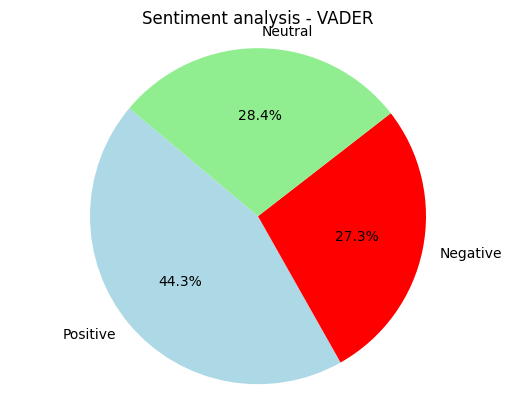

In [30]:
vader_value_counts = data_df['Sentiment_Vader'].value_counts()
plot_distribution(title = 'Sentiment analysis - VADER',values=[vader_value_counts['Positive'], vader_value_counts['Negative'], vader_value_counts['Neutral']])

In [31]:
positive_comments_vader = [sentiment for sentiment in data_df[data_df['Sentiment_Vader']=='Positive']['Processed_Text_String']]
negative_comments_vader  = [sentiment for sentiment in data_df[data_df['Sentiment_Vader']=='Negative']['Processed_Text_String']]
neutral_comments_vader = [sentiment for sentiment in data_df[data_df['Sentiment_Vader']=='Neutral']['Processed_Text_String']]

# generate word clouds
wordcloud_vader_pos = generate_word_cloud(positive_comments_vader)
wordcloud_vader_neg = generate_word_cloud(negative_comments_vader)
wordcloud_vader_neutral = generate_word_cloud(neutral_comments_vader)

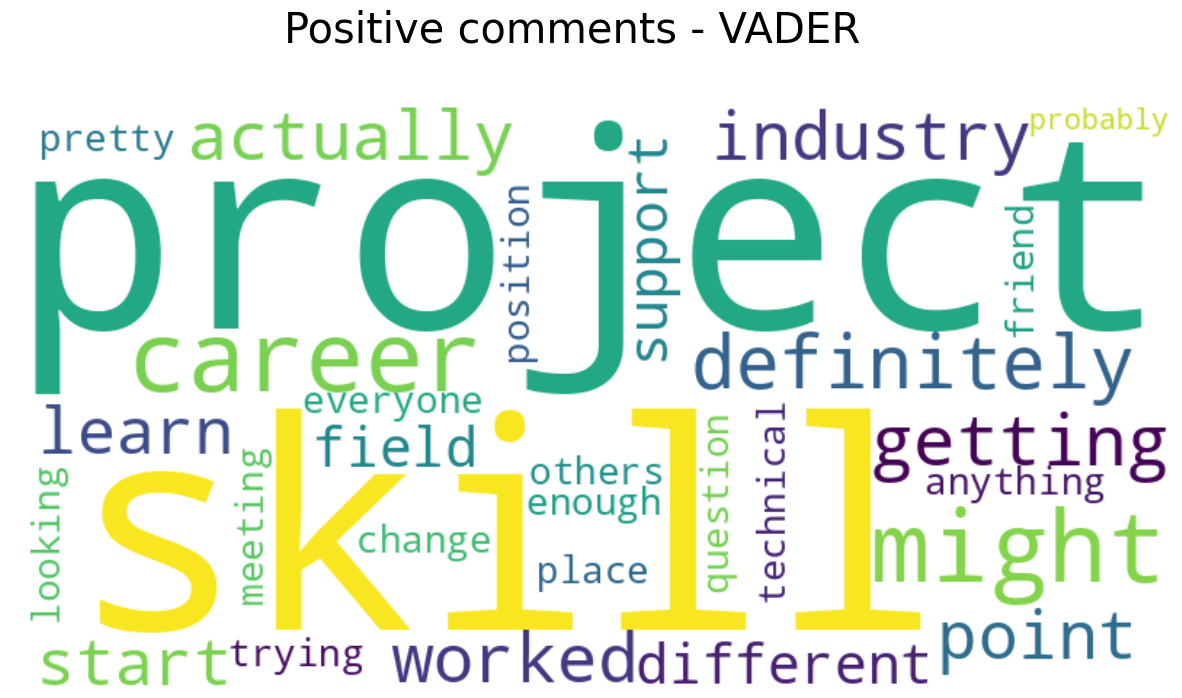

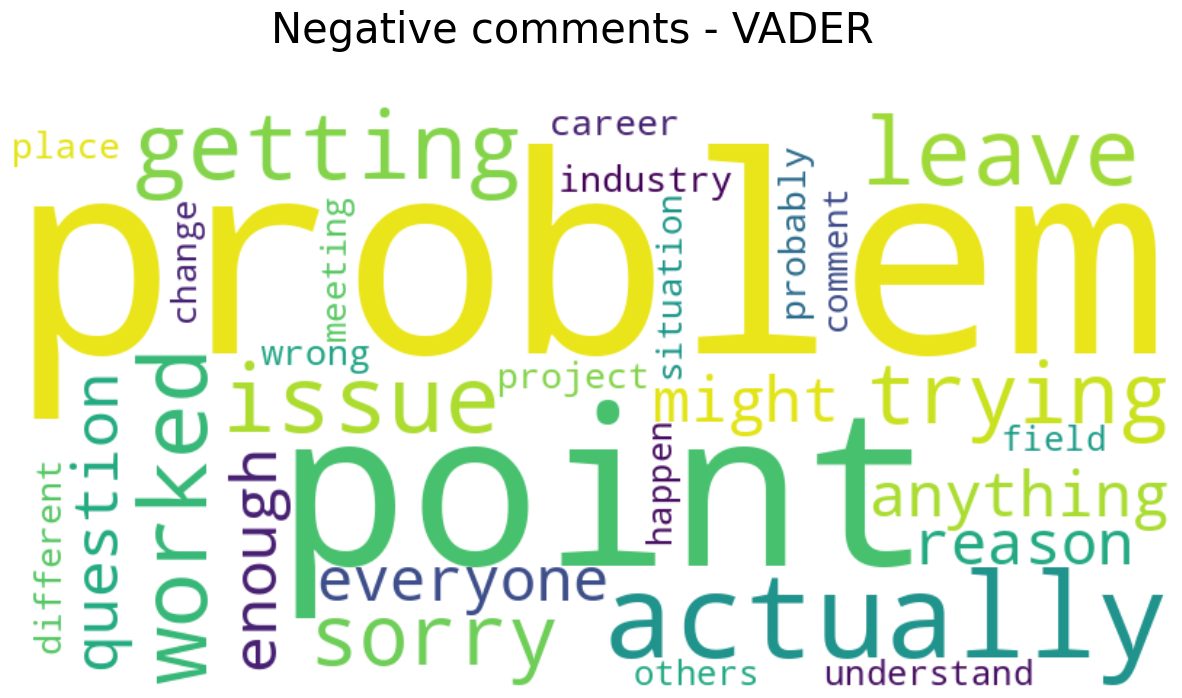

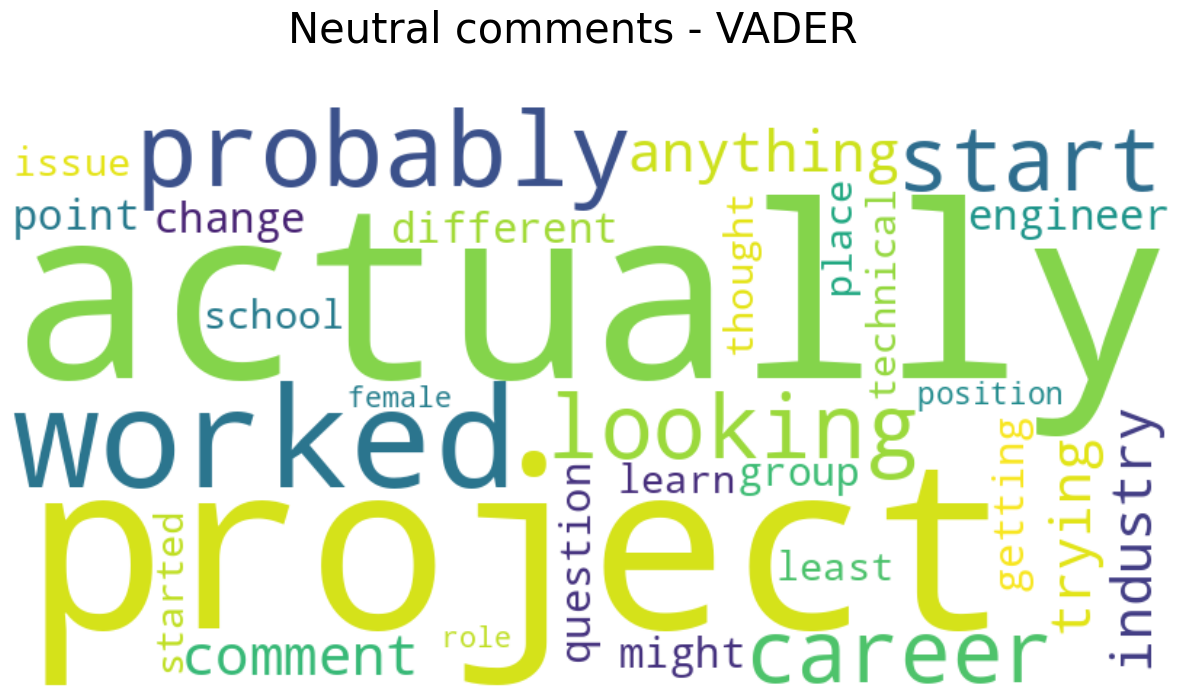

In [32]:
display_word_cloud(wordcloud_vader_pos, "Positive comments - VADER")
display_word_cloud(wordcloud_vader_neg, "Negative comments - VADER")
display_word_cloud(wordcloud_vader_neutral, "Neutral comments - VADER")

## Sentiment analysis with RoBERTa

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [34]:
# load model and tokenizer
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta).to(device)
tokenizer = AutoTokenizer.from_pretrained(roberta)

labels = ['Negative', 'Neutral', 'Positive']

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [35]:
def batch_tokenize(inputs, tokenizer, batch_size = 32):
  tokenized_batch = []
  for i in range(0, len(inputs), batch_size):
    batch = inputs[i:i + batch_size]
    tokenized_inputs = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length = 512)
    tokenized_inputs = {key: value.to(device) for key, value in tokenized_inputs.items()}
    tokenized_batch.append(tokenized_inputs)
  return tokenized_batch

In [36]:
def roberta_sentiment_score(inputs):
  model.eval()
  sentiments = []
  with torch.no_grad():
    for batch in inputs:
      logits = model(**batch).logits
      predictions = torch.softmax(logits, dim=-1)
      sentiments.extend(predictions.cpu())
  return sentiments

def roberta_sentiment(score, labels):
  sentiment_label = labels[torch.argmax(score).item()]
  return sentiment_label

In [37]:
tokenized_batch_inputs = batch_tokenize(data_df['Processed_Text_String'].tolist(), tokenizer)
predictions = roberta_sentiment_score(tokenized_batch_inputs)

In [38]:
data_df['Polarity_RoBERTa'] = predictions
data_df['Sentiment_RoBERTa'] = data_df['Polarity_RoBERTa'].apply(roberta_sentiment, labels = labels)
data_df['Polarity_RoBERTa'] = data_df['Polarity_RoBERTa'].apply(lambda x: x.numpy())
data_df['Sentiment_RoBERTa'].value_counts()

Sentiment_RoBERTa
Neutral     14045
Negative     4874
Positive     2641
Name: count, dtype: int64

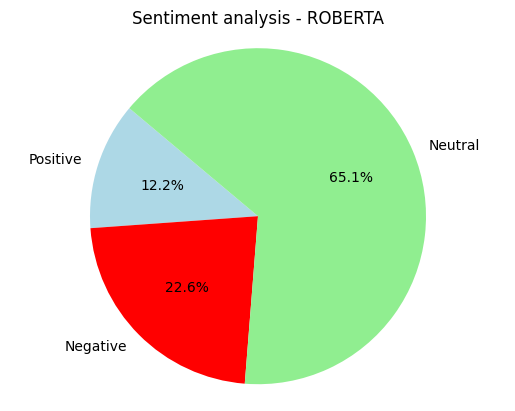

In [39]:
roberta_value_counts = data_df['Sentiment_RoBERTa'].value_counts()
plot_distribution(title = 'Sentiment analysis - ROBERTA',values=[roberta_value_counts['Positive'], roberta_value_counts['Negative'], roberta_value_counts['Neutral']])

In [40]:
positive_comments_roberta = [sentiment for sentiment in data_df[data_df['Sentiment_RoBERTa']=='Positive']['Processed_Text_String']]
negative_comments_roberta  = [sentiment for sentiment in data_df[data_df['Sentiment_RoBERTa']=='Negative']['Processed_Text_String']]
neutral_comments_roberta = [sentiment for sentiment in data_df[data_df['Sentiment_RoBERTa']=='Neutral']['Processed_Text_String']]

# generate word clouds
wordcloud_roberta_pos = generate_word_cloud(positive_comments_roberta)
wordcloud_roberta_neg = generate_word_cloud(negative_comments_roberta)
wordcloud_roberta_neutral = generate_word_cloud(neutral_comments_roberta)

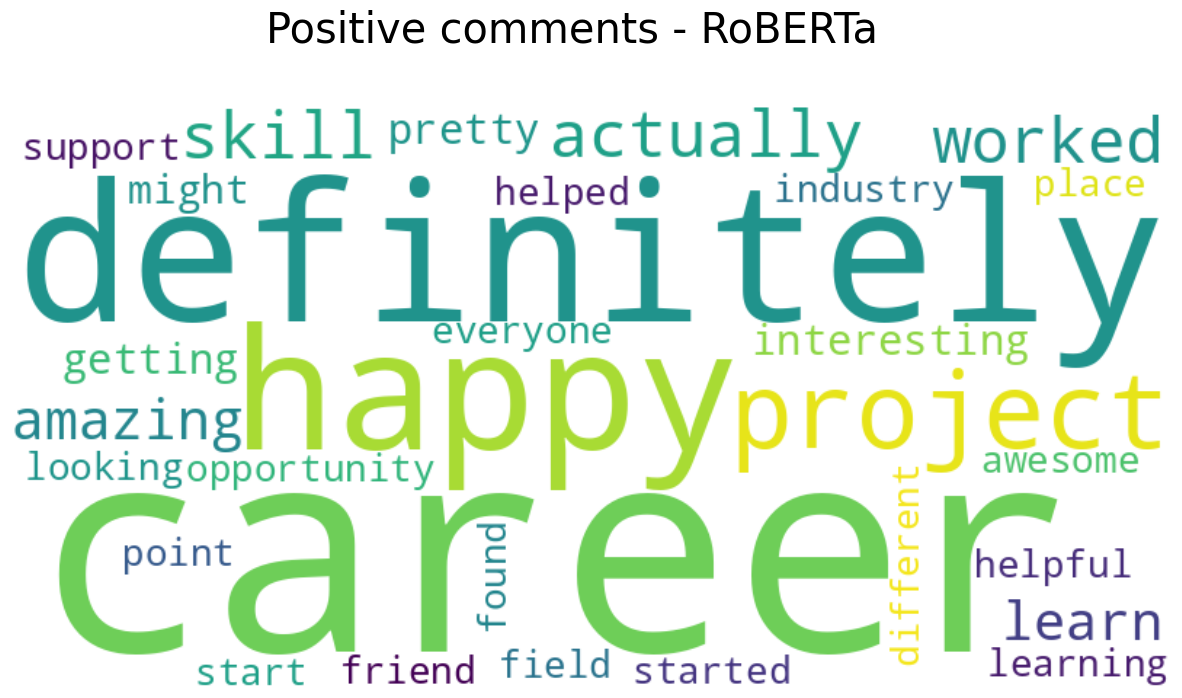

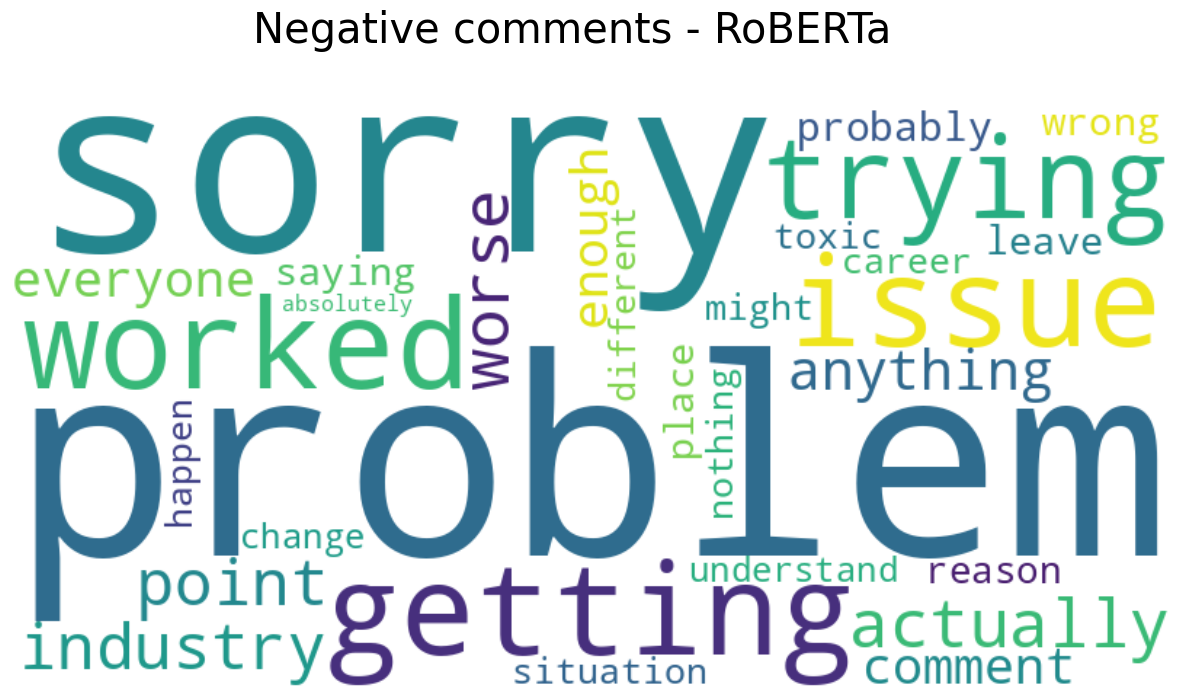

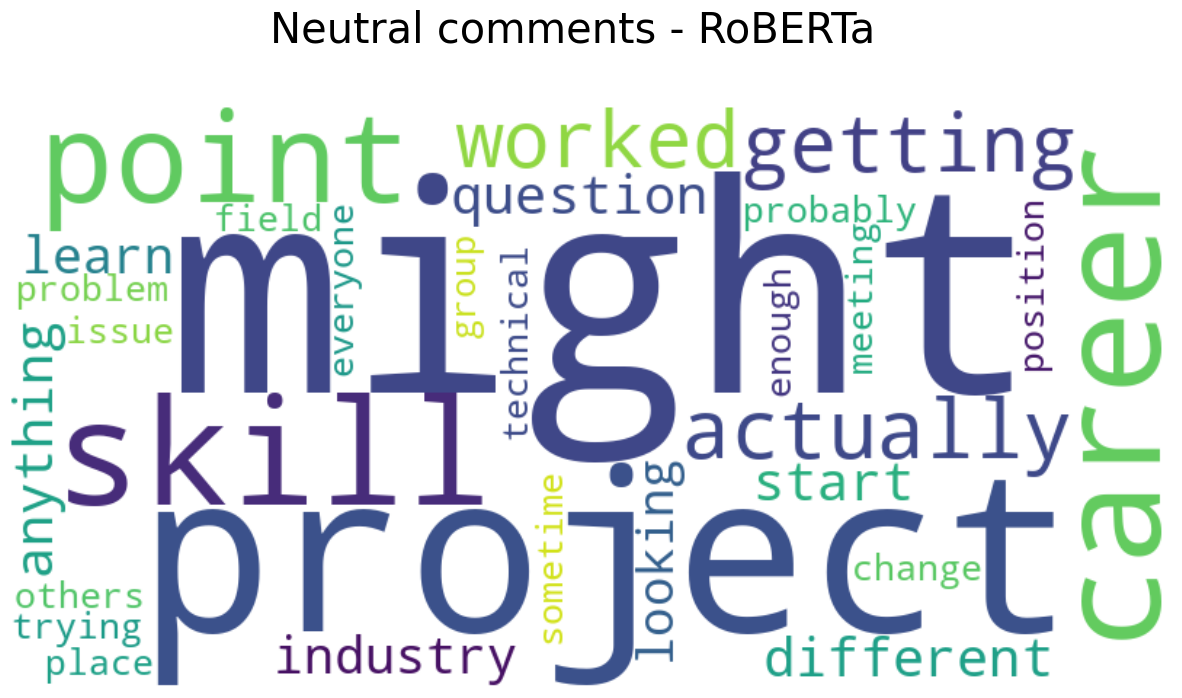

In [41]:
display_word_cloud(wordcloud_roberta_pos, "Positive comments - RoBERTa")
display_word_cloud(wordcloud_roberta_neg, "Negative comments - RoBERTa")
display_word_cloud(wordcloud_roberta_neutral, "Neutral comments - RoBERTa")

In [8]:
data_df = pd.read_csv("processed_data.csv")
data_df = data_df.dropna(subset=['Processed_Text'], how = 'any', axis = 0)
data_df = data_df.dropna(subset=['Processed_Text_String'], how = 'any', axis = 0)

rows_to_drop = data_df['Processed_Text'].apply(len) == 0
data_df.drop(data_df[rows_to_drop].index, inplace=True)
rows_to_drop = data_df['Processed_Text_String'].apply(len) == 0
data_df.drop(data_df[rows_to_drop].index, inplace=True)
data_df.reset_index(drop=True, inplace=True)
data_df.head()


Unnamed: 0   postid                                               text  \
0           0  189ahan  I've been in IT for 15 years, working with all...   
1           1  189ahan  I use SQL regularly and have never heard those...   
2           2  189ahan  I’m a very good senior programmer and an inter...   
3           3  189ahan  Wtf is a senior director doing interviewing a ...   
4           4  189ahan  I’ve been using SQL for 30 years, have an Orac...   

                                      Processed_Text  \
0  ['year', 'working', 'stuff', 'listed', 'varyin...   
1  ['regularly', 'never_heard', 'term', 'could', ...   
2  ['senior', 'programmer', 'interview', 'would',...   
3  ['senior_director', 'interviewing', 'junior', ...   
4  ['using', 'year', 'oracle', 'certification', '...   

                             Processed_Text_Filtered  \
0  ['stuff', 'listed', 'varying', 'capacity', 'an...   
1  ['regularly', 'never_heard', 'term', 'probably...   
2  ['senior', 'programmer', 'absolutely', 'judgin...   
3  ['senior_director', 'interviewing', 'junior', ...   
4  ['using', 'oracle', 'certification', 'written'...   

                               Processed_Text_String  Polarity_Vader  \
0  stuff listed varying capacity answer retain kn...         -0.3182   
1  regularly never_heard term probably provide qu...         -0.7778   
2  senior programmer absolutely judging respond b...         -0.6326   
3  senior_director interviewing junior need regar...          0.0000   
4  using oracle certification written parser talking          0.0000   

  Sentiment_Vader                    Polarity_RoBERTa Sentiment_RoBERTa  
0        Negative  [0.8056724  0.17200069 0.02232686]          Negative  
1        Negative  [0.901833   0.09292668 0.00524026]          Negative  
2        Negative  [0.34391496 0.61819917 0.03788592]           Neutral  
3         Neutral  [0.2552059  0.7152246  0.02956952]           Neutral  
4         Neutral  [0.07407638 0.87190795 0.05401569]           Neutral

## TOPIC MODELLING WITH LDA

In [43]:
posts_df = pd.read_csv("posts-WIT.csv", header=0)
posts_df = posts_df.dropna(subset=['text'], how = 'any', axis = 0)
posts_df['Processed_Text'] = posts_df['text'].apply(preprocess)
posts_df.head()

text  score       id  \
0  Candidate cried during interview--what would y...   1196  189ahan   
1                      Women Who Code will shut down   1182  1c7dabu   
2                            Discrimination at Apple    980  187s5r8   
3   Male colleagues walked away from the lunch table    762  17s3jgn   
4  [Ineffectual rant] My partner just did the thi...    642  1bqxcdg   

                                                link  num_of_comments  \
0  /r/womenintech/comments/189ahan/candidate_crie...              542   
1  /r/womenintech/comments/1c7dabu/women_who_code...              197   
2  /r/womenintech/comments/187s5r8/discrimination...              226   
3  /r/womenintech/comments/17s3jgn/male_colleague...              427   
4  /r/womenintech/comments/1bqxcdg/ineffectual_ra...               95   

                         Processed_Text  
0  [candidate, cried, interview, would]  
1                                    []  
2               [discrimination, apple]  
3     [colleague, walked, lunch, table]  
4         [ineffectual, partner, thing]

In [44]:
rows_to_drop = posts_df['Processed_Text'].apply(len) == 0
posts_df.drop(posts_df[rows_to_drop].index, inplace=True)
posts_df.reset_index(drop=True, inplace=True)
posts_df.head()

text  score       id  \
0  Candidate cried during interview--what would y...   1196  189ahan   
1                            Discrimination at Apple    980  187s5r8   
2   Male colleagues walked away from the lunch table    762  17s3jgn   
3  [Ineffectual rant] My partner just did the thi...    642  1bqxcdg   
4                                     Gee….thanks :|    622  186vhzb   

                                                link  num_of_comments  \
0  /r/womenintech/comments/189ahan/candidate_crie...              542   
1  /r/womenintech/comments/187s5r8/discrimination...              226   
2  /r/womenintech/comments/17s3jgn/male_colleague...              427   
3  /r/womenintech/comments/1bqxcdg/ineffectual_ra...               95   
4         /r/womenintech/comments/186vhzb/geethanks/               65   

                         Processed_Text  
0  [candidate, cried, interview, would]  
1               [discrimination, apple]  
2     [colleague, walked, lunch, table]  
3         [ineffectual, partner, thing]  
4                              [thanks]

In [45]:
# Build the bigram, trigram model
bigram = gensim.models.Phrases(posts_df['Processed_Text'], min_count = 5)
trigram = gensim.models.Phrases(bigram[posts_df['Processed_Text']])

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def build_bigrams(data):
    return [bigram_mod[x] for x in data]

def build_trigrams(data):
    return [trigram_mod[bigram_mod[x]] for x in data]

In [46]:
bigrams = build_bigrams(posts_df['Processed_Text'])
trigrams = build_trigrams(bigrams)

In [47]:
lda_dictionary = Dictionary(trigrams)
lda_dictionary.filter_extremes(no_below = 5, no_above = 0.5)
doc_term_matrix_posts = [lda_dictionary.doc2bow(x) for x in trigrams]

In [49]:
topics = []
score = []
for num_topics in range(3, 15):
  ldamodel = LdaModel(doc_term_matrix_posts, num_topics=num_topics, id2word=lda_dictionary, passes=20, alpha="auto", eta="auto", random_state = 10)
  cm = CoherenceModel(model=ldamodel, texts=trigrams, dictionary=lda_dictionary, coherence='c_v')
  coherence = cm.get_coherence()
  topics.append(num_topics)
  score.append(coherence)
  print(num_topics, " ", coherence)

3   0.6251614744015354
4   0.6517120996650598
5   0.6159070612038084
6   0.6477750646084621
7   0.6698685418840011
8   0.6631830298132833
9   0.6418391032568983
10   0.6304029824690592
11   0.6384933399649342
12   0.6343467821647744
13   0.6295277234513607
14   0.6236065712607338


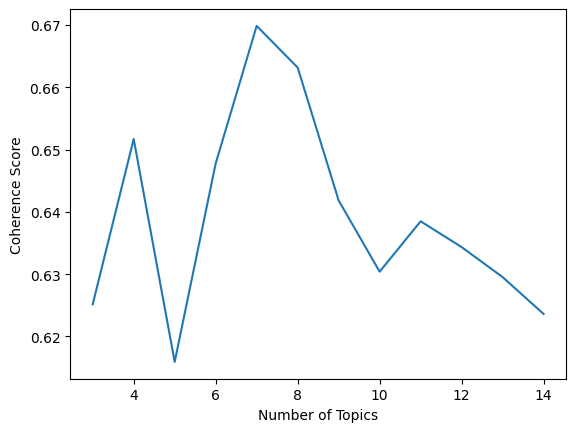

In [50]:
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [68]:
num_topics = 4
model = LdaModel(doc_term_matrix_posts, num_topics=num_topics, id2word=lda_dictionary, passes=20, alpha="auto", eta="auto", random_state = 10)

In [69]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, doc_term_matrix_posts, lda_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.211998 -0.174446       1        1  30.505237
1     -0.263461 -0.161715       2        1  26.708754
2      0.127684  0.098080       3        1  22.462973
0     -0.076220  0.238081       4        1  20.323035, topic_info=         Term       Freq      Total Category  logprob  loglift
52     advice  58.000000  58.000000  Default  30.0000  30.0000
50     career  44.000000  44.000000  Default  29.0000  29.0000
35    company  33.000000  33.000000  Default  28.0000  28.0000
0   interview  25.000000  25.000000  Default  27.0000  27.0000
13    manager  23.000000  23.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
89     gender   4.824209   9.057813   Topic4  -4.0349   0.9634
22    thought   3.831914   7.249863   Topic4  -4.2651   0.9558
59     friend   2.594584   6.340694   Topic4  -4.6551   0.6999
41  community   4.081790  10.836532   Topic4  -4.2020   0.6170
65     really   3.277141  13.651714   Topic4  -4.4215   0.1665

[162 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
52        3  0.989348   advice
131       2  0.826284  analyst
131       3  0.137714  analyst
114       3  0.553469  anxiety
114       4  0.368979  anxiety
...     ...       ...      ...
55        2  0.916904  working
1         2  0.990262    would
26        1  0.710389     year
26        2  0.193742     year
26        3  0.064581     year

[162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [70]:
posts_df['Topic'] = [[x[0] + 1 for x in sorted(model[doc_term_matrix_posts][i], key = lambda x: x[1], reverse = True)[:2]] for i in range(len(posts_df['text']))]
posts_df.head(10)

text  score       id  \
0  Candidate cried during interview--what would y...   1196  189ahan   
1                            Discrimination at Apple    980  187s5r8   
2   Male colleagues walked away from the lunch table    762  17s3jgn   
3  [Ineffectual rant] My partner just did the thi...    642  1bqxcdg   
4                                     Gee….thanks :|    622  186vhzb   
5             finally ready to leave tech, at age 55    610  1b4bqay   
6  I recently learned that work trauma is a legit...    603  19c63it   
7  Let's dismantle the "If you're being mistreate...    602  1bo7w4s   
8       What response would you have to this comment    581  18gxrzl   
9  25 year old McKinsey consultant commits suicid...    521  1boikvc   

                                                link  num_of_comments  \
0  /r/womenintech/comments/189ahan/candidate_crie...              542   
1  /r/womenintech/comments/187s5r8/discrimination...              226   
2  /r/womenintech/comments/17s3jgn/male_colleague...              427   
3  /r/womenintech/comments/1bqxcdg/ineffectual_ra...               95   
4         /r/womenintech/comments/186vhzb/geethanks/               65   
5  /r/womenintech/comments/1b4bqay/finally_ready_...              109   
6  /r/womenintech/comments/19c63it/i_recently_lea...               87   
7  /r/womenintech/comments/1bo7w4s/lets_dismantle...              136   
8  /r/womenintech/comments/18gxrzl/what_response_...              542   
9  /r/womenintech/comments/1boikvc/25_year_old_mc...               63   

                                      Processed_Text   Topic  
0               [candidate, cried, interview, would]  [2, 1]  
1                            [discrimination, apple]  [2, 4]  
2                  [colleague, walked, lunch, table]  [4, 2]  
3                      [ineffectual, partner, thing]  [3, 4]  
4                                           [thanks]  [4, 2]  
5                            [finally, ready, leave]  [4, 2]  
6  [recently, learned, trauma, legitimate, thing,...  [3, 4]  
7                 [dismantle, mistreated, narrative]  [4, 2]  
8                         [response, would, comment]  [2, 4]  
9  [mckinsey, consultant, commits, suicide, right...  [2, 4]

In [71]:
# group by the topic the post is assigned to
posts_topic = {i: [] for i in range(1, num_topics + 1)}
for idx, row in posts_df.iterrows():
    post_id = row['id']
    topics = row['Topic']
    for topic in topics:
        posts_topic[topic].append(post_id)

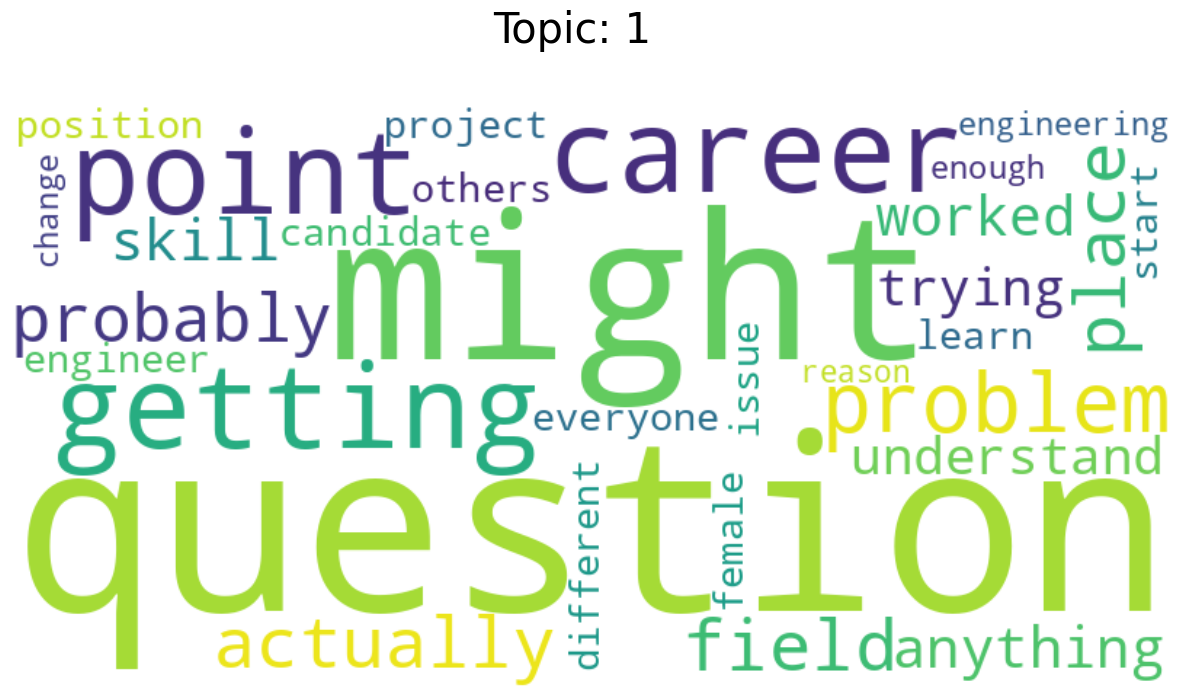

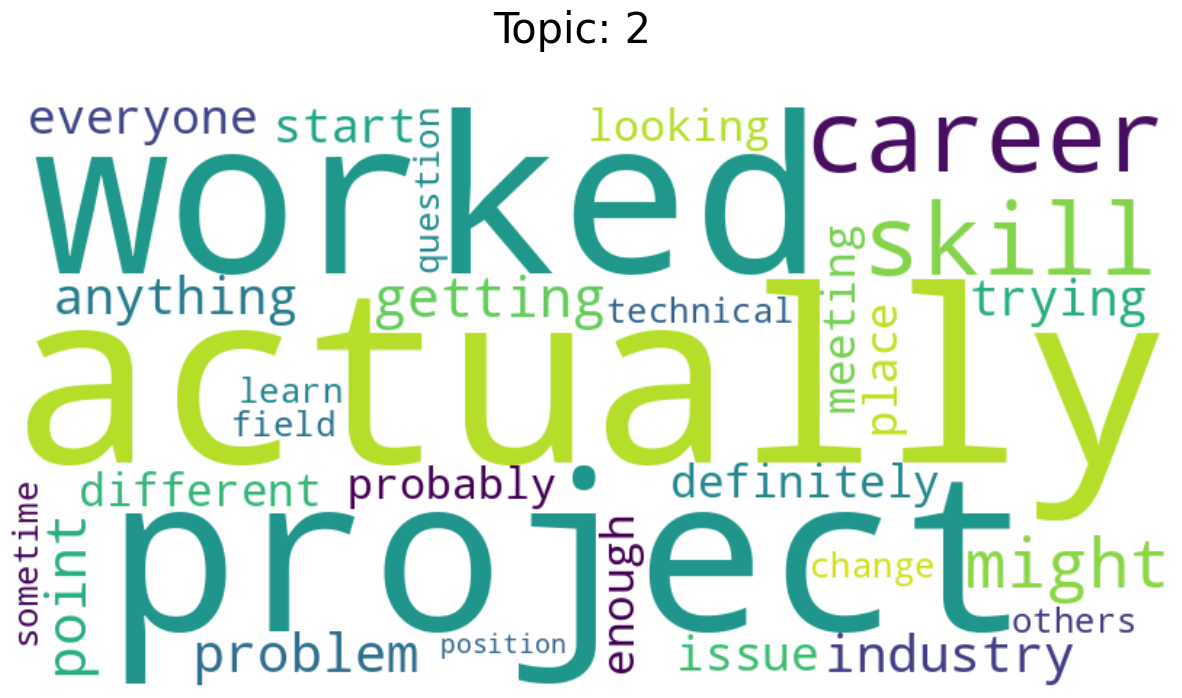

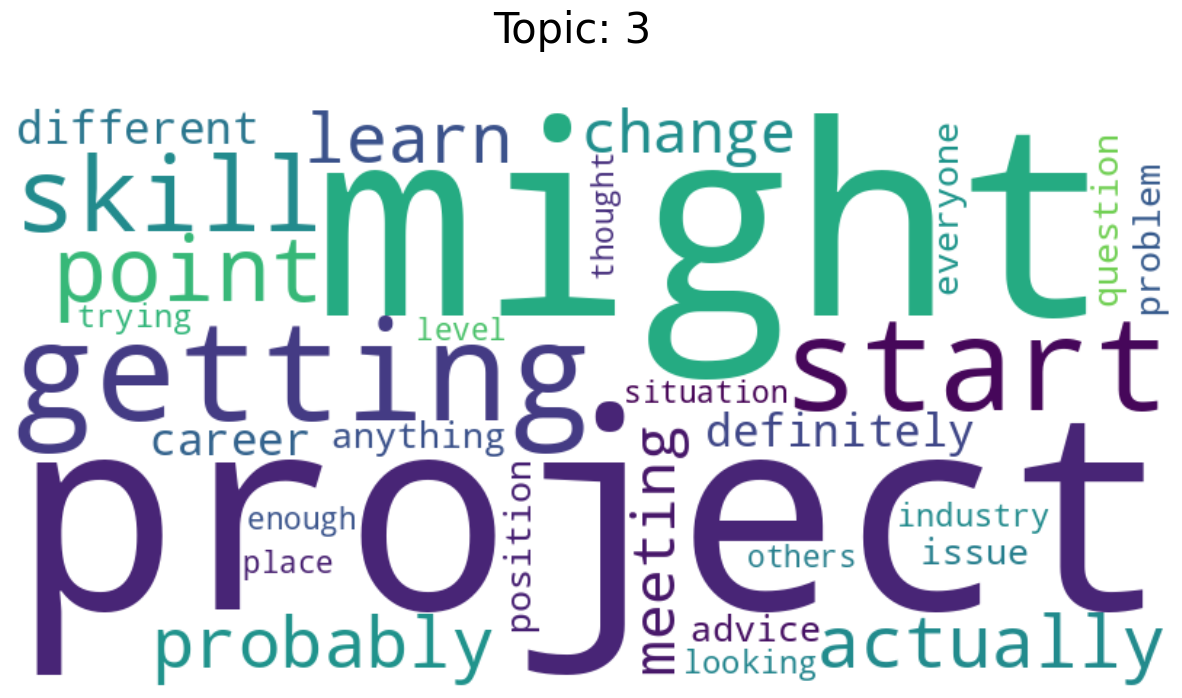

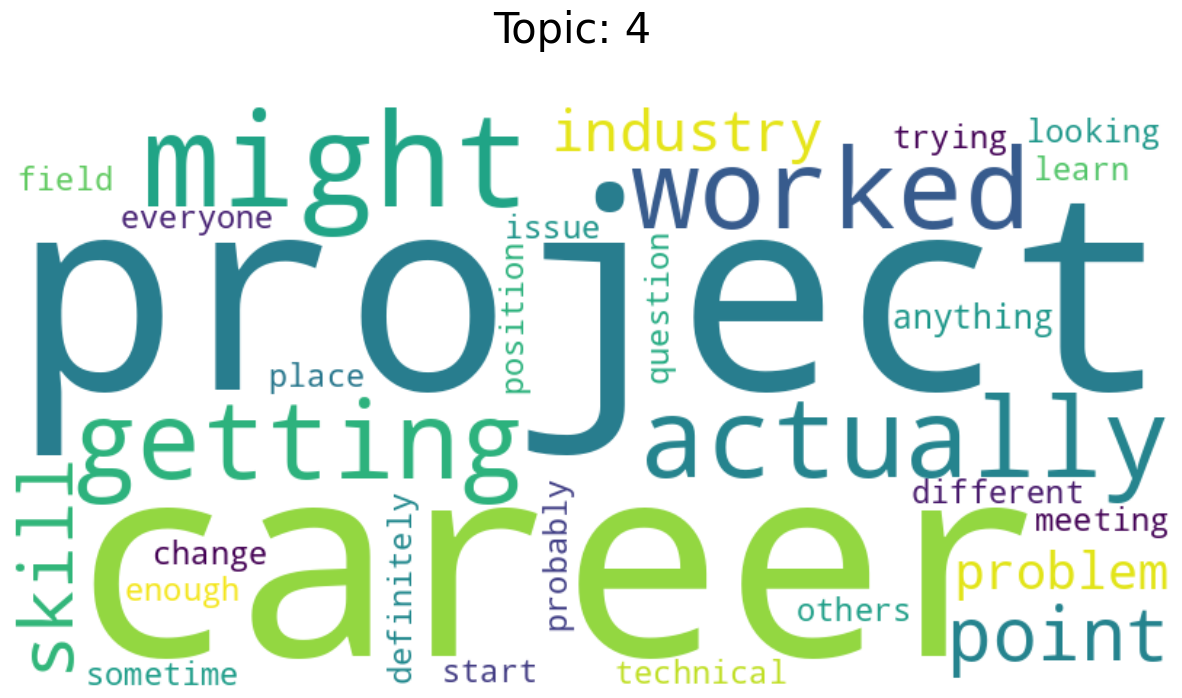

In [72]:
# Visualise word clouds for different topics
topic_indices = [str(i) for i in range(1, num_topics + 1)]
comments_sentiment_per_topic = {}
for idx, id_list in posts_topic.items():
  # get the comments for the topic
  topic_comments_df = data_df.query('postid in @id_list')
  comments = topic_comments_df['Processed_Text_String'].tolist()
  comments_sentiment_per_topic[idx] = comments
  wordcloud = generate_word_cloud(comments)
  display_word_cloud(wordcloud, "Topic: {0}".format(idx))

## Overall positive comments

Analyze comments that both the models labelled as positive

In [73]:
condition = (data_df["Sentiment_RoBERTa"] == 'Positive') & (data_df["Sentiment_Vader"] == 'Positive')
overall_pos_comments = data_df[condition]

len(overall_pos_comments)

2348

In [74]:
overall_pos_comments["text"].tail(10).to_list()

['Found your comment really helpful, I’m wondering if you’d be willing to share your currently role / sector? You mention the no love for coding so just curious - I’m a natural / career problem solver but not sure if coding is my bag but would really love to move into tech',
 'I’m biased because I can’t find stable work so take it with a huge grain, but federal. It’s so much safer right now. You’ll get a COLA every year and moving from job to job is much easier.',
 'Federal for long term. Better healthcare benefits. If you end up working federal jobs I think it opens doors to more opportunities.',
 'I love my job right now, but if I got laid off tomorrow, I’d go for a federal job. I prioritize security and happiness above pay.',
 'Thank you so much I will check it out. Appreciated',
 'Thank you that is very helpful!',
 'Definitely looking at that as an option. Thanks!',
 'Thank you so much, this is helpful!!',
 'Coursera greatly helped me with my transition into tech, and within tech. 

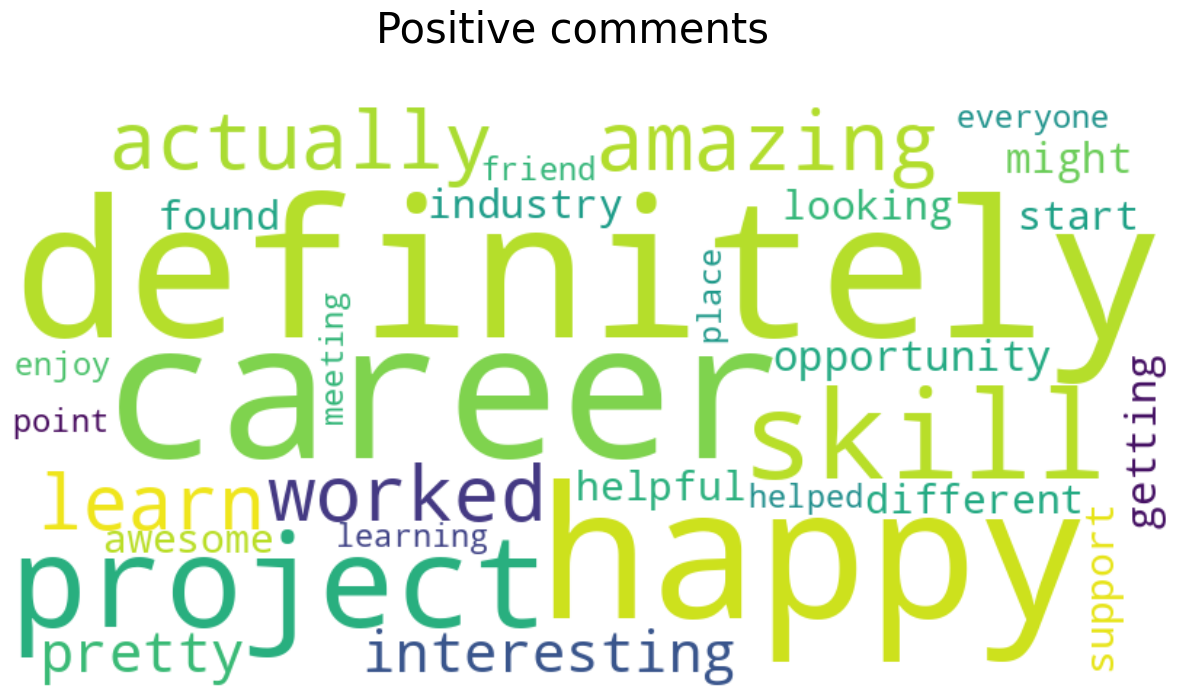

In [75]:
overall_pos_text = overall_pos_comments["Processed_Text_String"].to_list()
overall_pos_wordcloud = generate_word_cloud(overall_pos_text)
display_word_cloud(overall_pos_wordcloud, "Positive comments")

There are 2348 comments labelled as positive by both these models. Analysing a few of these show that they are indeed pretty positive and the wordcloud of these comments brings up some positive words as well!

## Overall negative comments

Analyze comments that both the models labelled as negative

In [76]:
condition = (data_df["Sentiment_RoBERTa"] == 'Negative') & (data_df["Sentiment_Vader"] == 'Negative')
overall_neg_comments = data_df[condition]

len(overall_neg_comments)

3314

In [77]:
overall_neg_comments["text"].head(20).to_list()

["I've been in IT for 15 years, working with all the stuff you listed in varying capacities. I couldn't answer these off hand, and no one that didn't retain the knowledge solely to pull it out of their ass decades later to sound smart would either. \n\nThat older asshole needs to be put in check, and stop fucking gatekeeping IT. \n\nDoes he want shit heads that memorize things, or does he want someone eager to learn and help and be a part of a team. He sucks. I'd apologize, and ignore the entire interview, and move forward based off of the info I got in a solo interview.",
 "I use SQL regularly and have never heard those terms even though I could probably provide a query with a definition. The other interviewers seem to be awful people, straight up. Idk if I would necessarily hire this person, but if I were you I'd report this entire thing to HR bc it was absolutely fucked up.",
 'Your team sucks and I hope she finds a better place to work',
 'Wow, that is awful.  I\'m really surprised

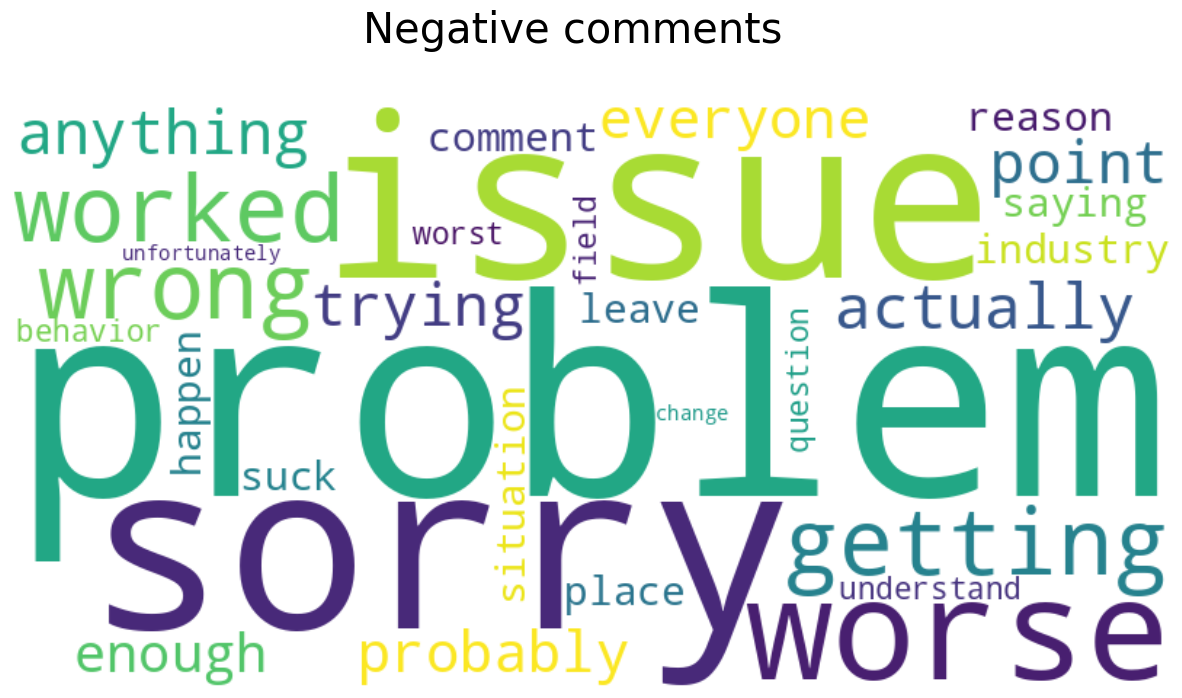

In [78]:
overall_neg_text = overall_neg_comments["Processed_Text_String"].to_list()
overall_neg_wordcloud = generate_word_cloud(overall_neg_text)
display_word_cloud(overall_neg_wordcloud, "Negative comments")

There are 3314 comments labelled as negative by both these models. Analysing a few of these show that they do sound negative and the wordcloud of these comments brings up some negative words.

## Overall analysis

In [79]:
def get_comment_sentiments_per_topic(groupByColumn):
  topic_indices = [str(i) for i in range(1, num_topics + 1)]
  comments_sentiment_per_topic = {}
  for idx, id_list in posts_topic.items():
    topic_comments_df = data_df.query('postid in @id_list')
    comments_sentiment_df = topic_comments_df.groupby(groupByColumn)
    comments_lists = {name: [] for name, _ in comments_sentiment_df}
    comments_lists = {name: list(group['Processed_Text_String']) for name, group in comments_sentiment_df}
    comments_sentiment_per_topic[idx] = comments_lists
  return comments_sentiment_per_topic

def generate_topic_sentiment_wordclouds(groupByColumn):
  topic_indices = [str(i) for i in range(1, num_topics + 1)]
  comments_sentiment_per_topic = get_comment_sentiments_per_topic(groupByColumn)
  for idx, id_list in posts_topic.items():
    comments_lists = comments_sentiment_per_topic[idx]
    fig, ax = plt.subplots(1,3, figsize=(15,8))
    i = 0
    # generate word clouds
    for sentiment, comments in comments_lists.items():
      wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=20, stopwords = stop_words).generate(" ".join(comment for comment in comments))
      ax[i].imshow(wordcloud, interpolation="bilinear")
      ax[i].set_title("Topic: {0}, Sentiment: {1}".format(idx, sentiment))
      i += 1


## ROBERTA

Analyse comments labelled as positive, negative and neutral by RoBERTa, for each topic.

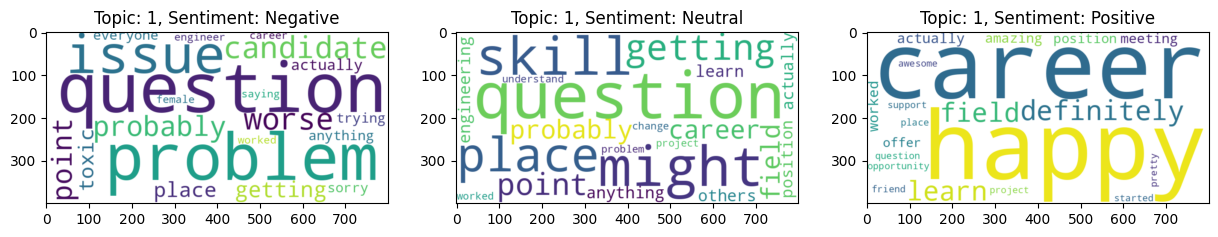

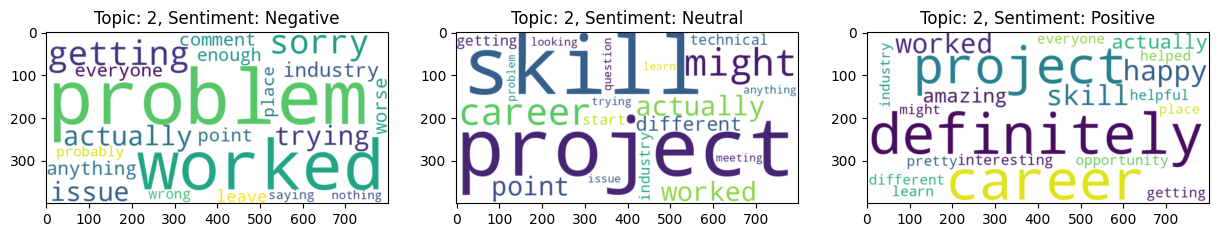

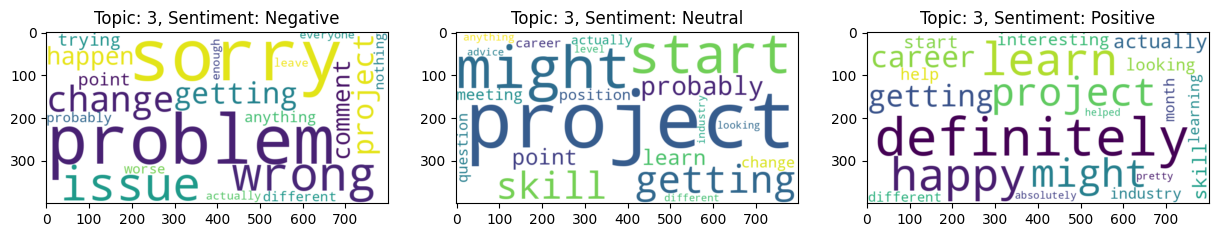

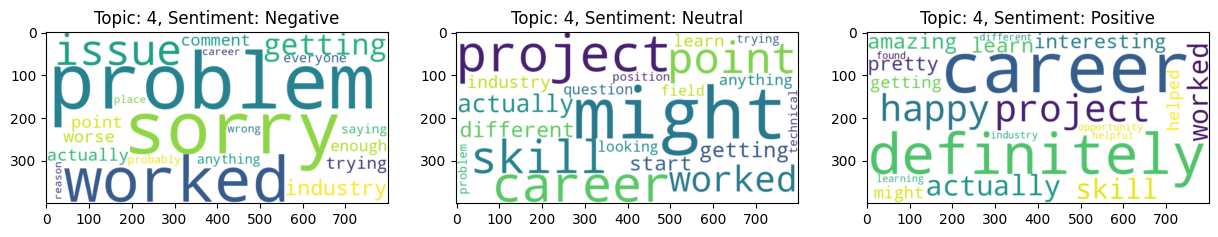

In [80]:
generate_topic_sentiment_wordclouds("Sentiment_RoBERTa")

## VADER

Analyse comments labelled as positive, negative and neutral by VADER for each topic.

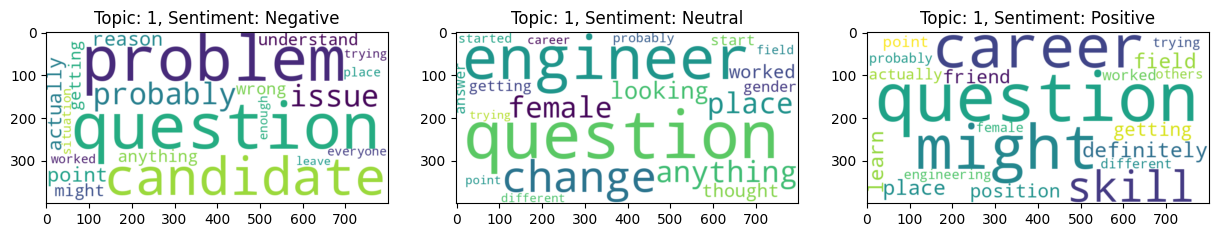

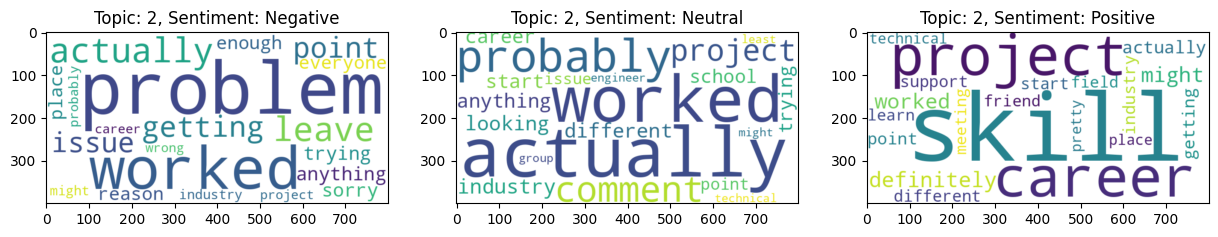

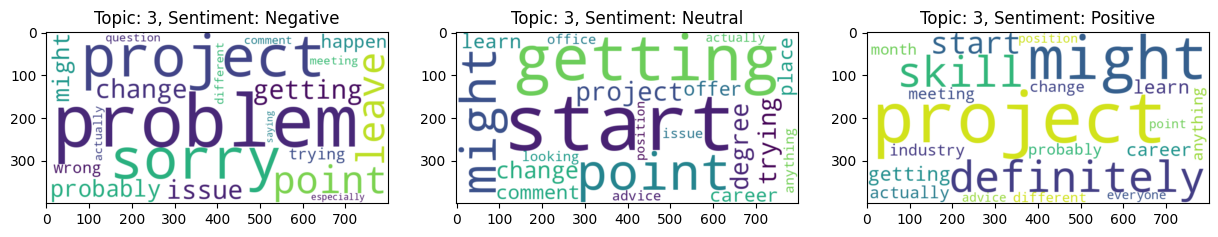

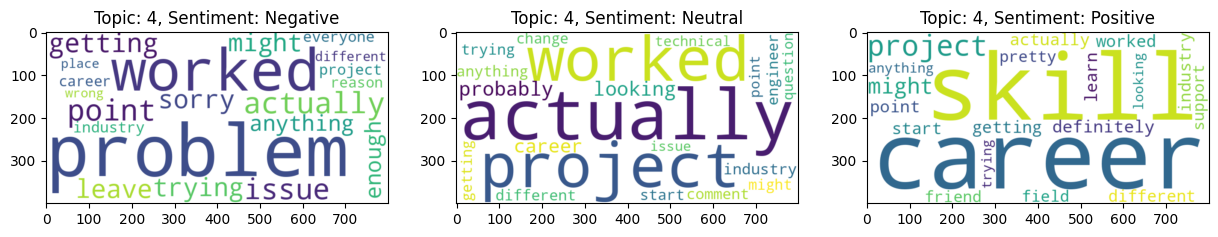

In [87]:
generate_topic_sentiment_wordclouds("Sentiment_Vader")

## Overall analysis

In [85]:
# Distribution across each topic
def generate_topic_sentiment_distribution():
  topic_indices = [str(i) for i in range(1, num_topics + 1)]
  comments_sentiment_per_topic_roberta = get_comment_sentiments_per_topic("Sentiment_RoBERTa")
  comments_sentiment_per_topic_vader = get_comment_sentiments_per_topic("Sentiment_Vader")
  for idx, id_list in posts_topic.items():
    fig, ax = plt.subplots(1,2, figsize=(8,8))
    comments_lists_vader = comments_sentiment_per_topic_vader[idx]
    comments_lists_roberta = comments_sentiment_per_topic_roberta[idx]
    ax[0].pie([len(comments_lists_vader['Positive']), len(comments_lists_vader['Negative']), len(comments_lists_vader['Neutral'])], labels=["Positive", "Negative", "Neutral"], autopct='%1.1f%%', startangle=140, colors = ['lightblue', 'red', 'lightgreen'])
    ax[0].set_title("Topic: {0} - {1}".format(idx, "VADER"))
    ax[1].pie([len(comments_lists_roberta['Positive']), len(comments_lists_roberta['Negative']), len(comments_lists_roberta['Neutral'])], labels=["Positive", "Negative", "Neutral"], autopct='%1.1f%%', startangle=140, colors = ['lightblue', 'red', 'lightgreen'])
    ax[1].set_title("Topic: {0} - {1}".format(idx, "ROBERTA"))
  plt.tight_layout()

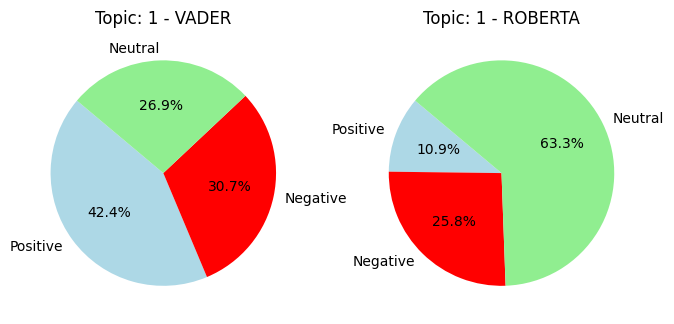

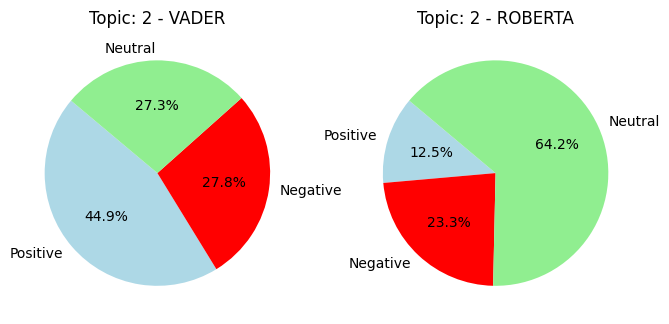

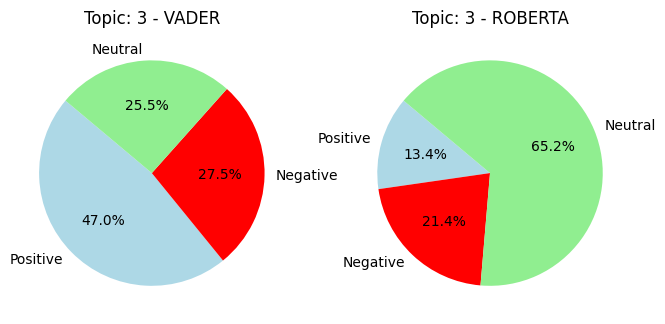

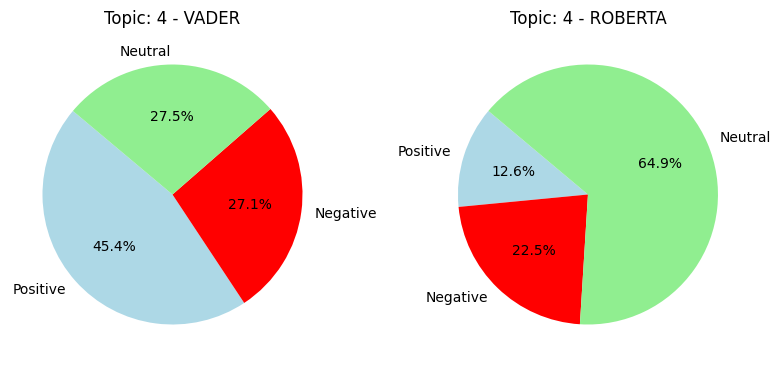

In [86]:
generate_topic_sentiment_distribution()

The word clouds across topics and sentiments show that RoBERTa identified words that are positive in nature and context.

In [ ]:
different_sentiments = data_df[data_df["Sentiment_RoBERTa"] != data_df["Sentiment_Vader"]]
len(different_sentiments)

10571

In [9]:
def get_different_sentiments(filter_column, compare_column, sentiment):
  data = data_df[(data_df[filter_column] == sentiment) & (data_df[compare_column] != sentiment)]
  return data[['text', 'Processed_Text', filter_column, compare_column]]

In [30]:
# Comments that RoBERTa classified as positive, but VADER classified it as either negative or neutral
different_sentiments_positive_roberta = get_different_sentiments('Sentiment_RoBERTa', 'Sentiment_Vader', 'Positive')
display(HTML(different_sentiments_positive_roberta.tail(10).to_html()))

In [11]:
different_sentiments_positive_roberta['Sentiment_Vader'].value_counts()

Sentiment_Vader
Neutral     210
Negative     83
Name: count, dtype: int64

A few strongly positive sentences are labelled as neutral by VADER. For example: That makes me so happy! Thank you!!! Can't wait to chat more :)

In [26]:
# Comments that RoBERTa classified as negative, but VADER classified it as either positive or neutral
different_sentiments_negative_roberta = get_different_sentiments('Sentiment_RoBERTa', 'Sentiment_Vader', 'Negative')
display(HTML(different_sentiments_negative_roberta.head(10).to_html()))

In [13]:
different_sentiments_negative_roberta['Sentiment_Vader'].value_counts()

Sentiment_Vader
Positive    976
Neutral     584
Name: count, dtype: int64

In [25]:
display(HTML(different_sentiments_negative_roberta[different_sentiments_negative_roberta['Sentiment_Vader'] == 'Positive'].head().to_html()))

Most of the comments that RoBERTa labelled as positive are labelled as negative by VADER. On looking at a few of these, it can be seen that VADER does not do a good job of classifying the sentiment.

In [24]:
# Comments that VADER classified as positive, but RoBERTa classified it as either negative or neutral
different_sentiments_positive_vader = get_different_sentiments('Sentiment_Vader', 'Sentiment_RoBERTa', 'Positive')
display(HTML(different_sentiments_positive_vader.tail(10).to_html()))

In [19]:
different_sentiments_positive_vader['Sentiment_RoBERTa'].value_counts()

Sentiment_RoBERTa
Neutral     6225
Negative     976
Name: count, dtype: int64

In [23]:
# Comments that VADER classified as negative, but RoBERTa classified it as either positive or neutral
different_sentiments_negative_vader = get_different_sentiments('Sentiment_Vader', 'Sentiment_RoBERTa', 'Negative')
display(HTML(different_sentiments_negative_vader.tail(10).to_html()))

In [21]:
different_sentiments_negative_vader['Sentiment_RoBERTa'].value_counts()

Sentiment_RoBERTa
Neutral     2493
Positive      83
Name: count, dtype: int64

VADER is a lexicon and rule-based sentiment analysis tool, which assigns predefined positive, negative, or neutral scores to individual words or phrases within the text. It computes the overall score by aggregating these individual scores and does not take into account the relationship between words. RoBERTa on the other hand is a transformer based model, which considers the context and relationships between words in a given text.

Overall, it can be seen that RoBERTa does a better job at analysing the sentiment of various comments. While RoBERTa offers more contextual analysis, VADER is fast and easy to use.

In [88]:
data_df.to_csv("processed_data.csv")
files.download("processed_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>